In [293]:
import pandas as pd
import numpy as np
from dataset import dict
import matplotlib.pyplot as plt
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

$\textbf{Introduction:}$

This DEX does not support an order book, the market is only made of market orders placed at all times and only the ones that are executed within 30 seconds of being sent are affecting the market and showing on the API.

What we call order book here is the flow of transactions that were done on-chain for this 12 hours window on the pair SOL / $LYNK.

We were curious to see what we could exhibit the statistical properties of the $LYNK memecoin that exhibit how stable this token compared to the very erratic behavior of a lot of the small marketcap tokens being traded on Raydium.

$\textbf{Exploring data and trading impact:}$

In [294]:
def access_spread(order_book):
    spread = {}
    for i in range(1, len(order_book)):
        if order_book['Type'][i] != order_book['Type'][i-1]:
            spread[i] = order_book['Price'][i-1] - order_book['Price'][i] #Execution post
    return spread

def process_order_book(order_book):
    timestamps = order_book.TradeTime
    buy_impact = {}
    sell_impact = {}
    for i in range(1, len(order_book)):
        if order_book.Type[i] == 'buy':
            buy_impact[i] = [order_book.PriceInUSD.iloc[i] - order_book.PriceInUSD.iloc[i-1], float(order_book.AmountInUSD.iloc[i])]
        else:
            sell_impact[i] = [order_book.PriceInUSD.iloc[i] - order_book.PriceInUSD.iloc[i-1], float(order_book.AmountInUSD.iloc[i])]
    return buy_impact, sell_impact, timestamps

In [295]:
order_book = pd.DataFrame([[x['Block']['allTime'], x['Trade']['Side']['Type'], x['Trade']['Side']['AmountInUSD'], x['Trade']['PriceInUSD'], x['Trade']['Price'], x['Trade']['Amount']] for x in dict['Solana']['DEXTradeByTokens']], columns = ['TradeTime', 'Type', 'AmountInUSD', 'PriceInUSD', 'Price', 'Amount'])
order_book = order_book.iloc[::-1].reset_index(drop=True)

In [296]:
order_book[[c for c in order_book.columns if c not in ['Type', 'TradeTime']]] = order_book[[c for c in order_book.columns if c not in ['Type', 'TradeTime']]].applymap(float)

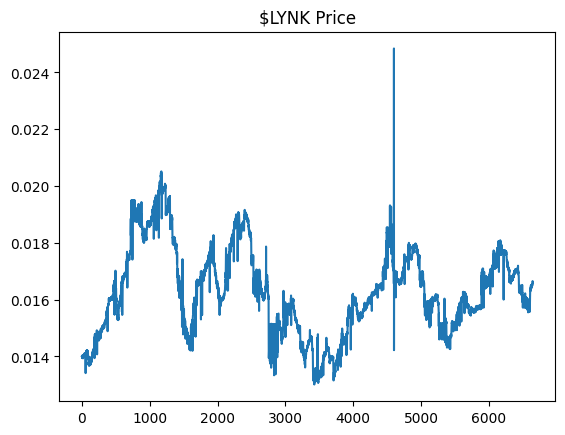

In [297]:
order_book.PriceInUSD.plot()
plt.title('$LYNK Price')
plt.show()

In [298]:
order_book

,TradeTime,Type,AmountInUSD,PriceInUSD,Price,Amount
0,2025-01-30T23:05:43Z,buy,12.479114,0.014006,0.000058,891.003298
1,2025-01-30T23:06:19Z,buy,72.180176,0.014010,0.000058,5152.212527
2,2025-01-30T23:06:25Z,sell,1.306340,0.013943,0.000058,93.692699
3,2025-01-30T23:06:27Z,sell,1.847617,0.013943,0.000058,132.515280
4,2025-01-30T23:07:46Z,buy,26.423768,0.014005,0.000058,1886.687419
...,...,...,...,...,...,...
6643,2025-01-31T10:44:14Z,buy,100.806298,0.016585,0.000070,6078.166009
6644,2025-01-31T10:44:16Z,buy,1216.186820,0.016651,0.000071,73040.795089
6645,2025-01-31T10:44:18Z,sell,5.040861,0.016628,0.000071,303.151151
6646,2025-01-31T10:45:07Z,sell,121.107468,0.016622,0.000071,7286.017909


$\textbf{Trading impact:}$

Averaging the observed trading impact every 2 minutes to see the dynamics of the impact over this timeframe.

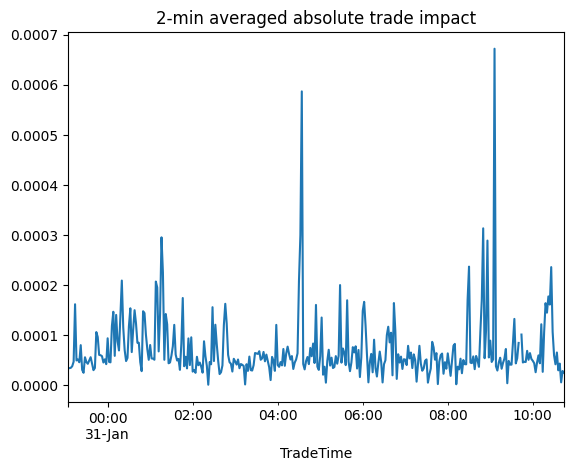

In [299]:
order_book['Trade impact'] = (order_book.PriceInUSD - order_book.PriceInUSD.shift(1)).abs()
impact = order_book['Trade impact']
impact.index = pd.to_datetime(order_book.TradeTime)
impact.resample('2T').mean().plot()
plt.title('2-min averaged absolute trade impact')
plt.show()

I split now the buy and sell impact by picking only the price fluctuation when a buy order follows directly a sell order and the other way around to measure the effective spread, I also stored the USD volume of the transactions to understand the effect of volume on that effective spread.

In spread_lynk, I stored any bid-ask bounce while the buy_impact_lynk and sell_impact_lynk are splitting the bid -> ask bounce and ask -> bid bounce to infer as being the trade impact.

In [300]:
buy_impact_lynk, sell_impact_lynk, timestamps_lynk = process_order_book(order_book)
spread_lynk = access_spread(order_book)

In [301]:
spread_accessed = pd.Series(spread_lynk.values(), index=pd.to_datetime(timestamps_lynk.loc[spread_lynk.keys()])).abs()
average_spread = spread_accessed.resample('2T').mean()

<Axes: xlabel='TradeTime'>

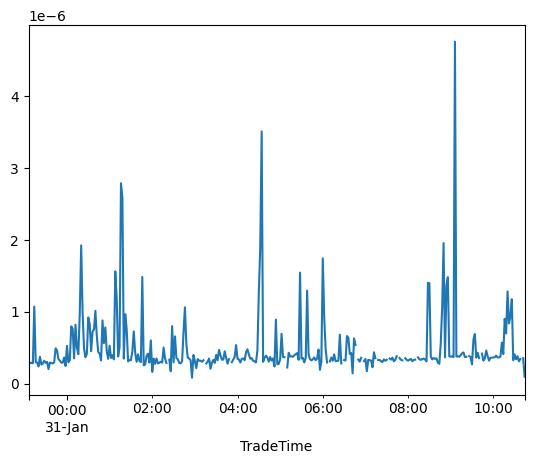

In [302]:
average_spread.plot()

$\textbf{Price impact of buy and sell pressure:}$

After cleaning out out the data by restricting myself to the trades of $\geq$ 500 USD and with the correct sign impact on the pair (when multiple trades are executed at about same times, the effective impact can often be biased if I can't observed the correct price witnessed after the trade), I can now exhibit the linear impact of the USD traded volume on the price.

This pair is specific as 76% of the token supply has been locked by the issuer, it has been said around in Spaces that it meant that bearish market participants cannot have an as dramatic impact on the price as the impact of the bulish market participants.

We can confirm this claim statistically as the price impact observed is linear with an asymmetry between the sell and buy regression coefficient.

We multiplied by 10**8 the regression coefficient to have a clearer quantity to compare: the buy pressure has an impact 25% higher on the price upwards than the sell pressure on the price downwards.

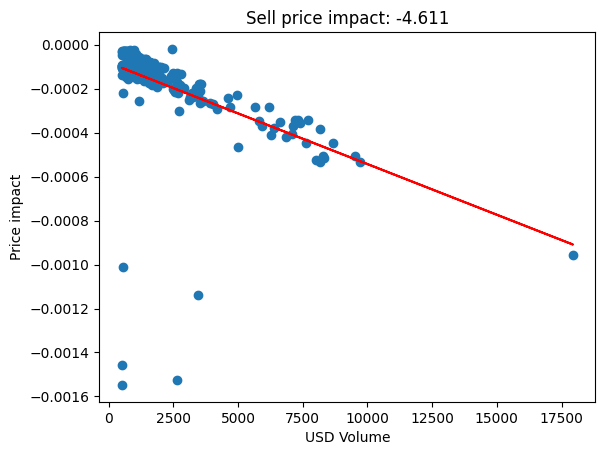

In [303]:
sell_impact = pd.DataFrame(sell_impact_lynk).T.reset_index(drop=True)
sell_impact.columns = ['Price impact', 'Amount']
big_sales = (sell_impact['Amount'] > 500) * (sell_impact['Price impact'] < 0)
x = sell_impact['Amount'].loc[big_sales]
y = sell_impact['Price impact'].loc[big_sales]
slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.scatter(x, y)
plt.plot(x, slope * x + intercept, color='red', label=f'Linear fit: y={slope:.2f}x + {intercept:.2f}')
plt.title(f'Sell price impact: {round(10**8 * slope,3)}')
plt.xlabel('USD Volume')
plt.ylabel('Price impact')
plt.show()

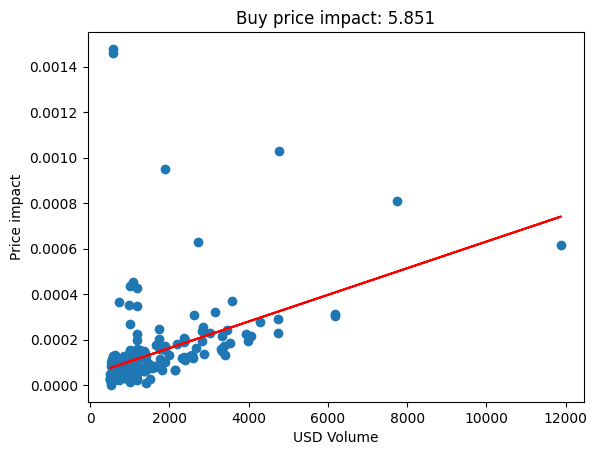

In [304]:
buy_impact = pd.DataFrame(buy_impact_lynk).T.reset_index(drop=True)
buy_impact.columns = ['Price impact', 'Amount']
big_buys = (buy_impact['Amount'] > 500) * (buy_impact['Price impact'] > 0)
x = buy_impact['Amount'].loc[big_buys]
y = buy_impact['Price impact'].loc[big_buys]
slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.scatter(x, y)
plt.plot(x, slope * x + intercept, color='red', label=f'Linear fit: y={slope:.2f}x + {intercept:.2f}')
plt.title(f'Buy price impact: {round(10**8 * slope,3)}')
plt.xlabel('USD Volume')
plt.ylabel('Price impact')
plt.show()

$\textbf{Volatility dynamics:}$

I am going to use realized volatility on short timeframes as proxy for the volatility and see if it fits effectively a rough volatility model, and the corresponding Hurst exponent to use to better understand and forecast the volatility's behavior to inform the $LYNK community.

To limit the noisyness, I removed the transactions below 1$ before computing the realized volatility estimations.

In [305]:
significant_transactions_lynk = order_book[order_book.Amount >= 1]

lynk_price = significant_transactions_lynk.PriceInUSD

lynk_times = pd.to_datetime(timestamps_lynk)
lynk_price.index = lynk_times.loc[lynk_price.index]
lynk_volume = order_book.Amount
lynk_volume.index = lynk_times.loc[lynk_volume.index]

In [306]:
def buy_sell_sign(x):
    if x == 'buy':
        return 1
    else:
        return -1

This is computing the realized volatility on 10 minutes windows.
I am aware that it is very small time windows to estimate volatility, but due to limited data, this was one of the ways around that we found to have sufficient points to infer an exponent.

In [307]:
realized_volatility = np.sqrt((np.log(lynk_price).diff()**2).resample('10T').sum())

<Axes: xlabel='TradeTime'>

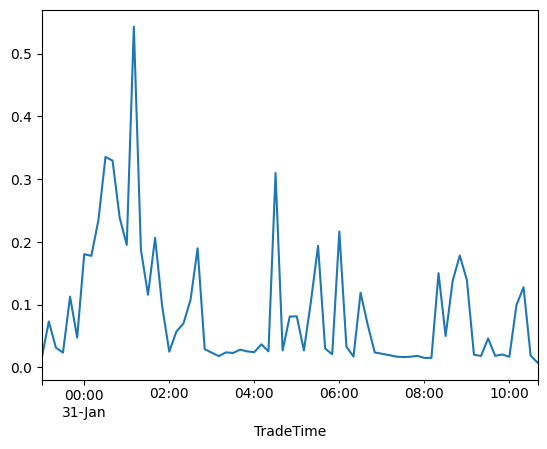

In [308]:
realized_volatility.plot()

We are looking at the expected value of $\mathbb{E}[|\sigma_{t+\Delta} - \sigma_{t}|^{q}]$ over all observed times t with the realized volatility computed above as proxy.
To infer a rough volatility model from the data, we expect this to be proportional to $\Delta^{H * q}$.

Hence, we plot below the logarithm of that expectation as a function of $\log(\Delta)$ and displayed below the $\alpha$ coefficient of the Least Squares linear regression divided by q, and expect that all the adjusted coefficients are approximatively identical.

In [309]:
delta = range(1,20)
q = np.linspace(1, 2, 7)
dict_vol = {}
for x in q:
    L = []
    for d in delta:
        L.append(((realized_volatility.shift(d) - realized_volatility).abs()**x).mean())
    dict_vol[x] = L


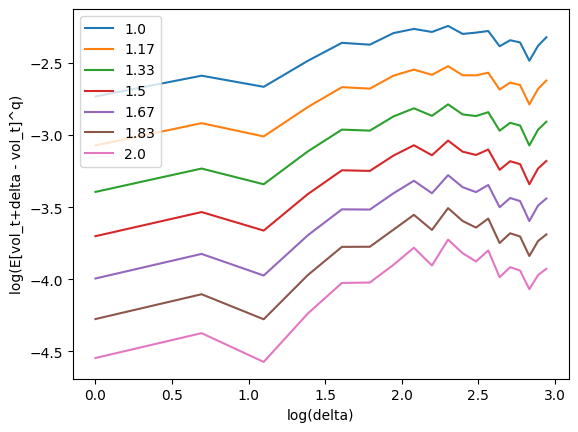

1.000000    0.136035
1.166667    0.132546
1.333333    0.130065
1.500000    0.128316
1.666667    0.127113
1.833333    0.126330
2.000000    0.125878
dtype: float64

In [310]:
H = pd.Series({x : np.cov(np.log(dict_vol[x]), np.log(delta))[0, 1] / (np.var(np.log(delta)) * x) for x in q})
for x in q:
    plt.plot(np.log(delta), np.log(dict_vol[x]))
plt.xlabel('log(delta)')
plt.ylabel('log(E[vol_t+delta - vol_t]^q)')
plt.legend(q.round(2))
plt.show()

H

Although the data is very limited (which is to be expected as the lives of memecoins are often very short, making it hard to make significant data analytics), we can on a first approximation say that this pair exhibits rough volatility dynamics with exponents of approximatively $H = 0.13$.



$\textbf{USD Volume dynamics:}$

We conclude by plotting the dynamics of the cumulative signed USD volume on the pair, that measures the cumulative buy pressure.

In [311]:
signs = order_book.Type.apply(buy_sell_sign)
signs.index = lynk_times.loc[signs.index]
lynk_signed_volume = lynk_volume * signs
lynk_volumeT = lynk_volume.rolling(10).sum().resample('1T').mean()

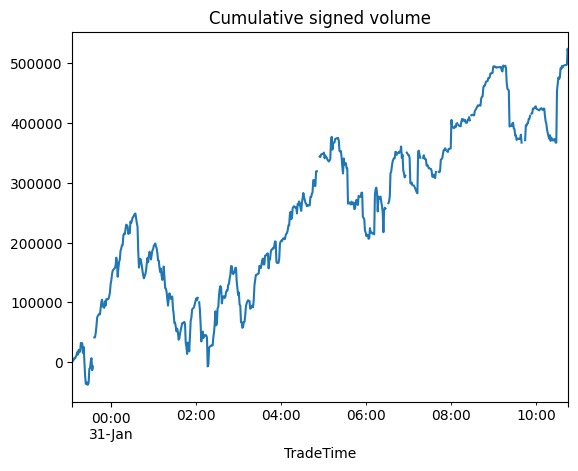

In [312]:
lynk_signed_volume.resample('1T').mean().cumsum().plot()
plt.title('Cumulative signed volume')
plt.show()